In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import torch
import scipy
from tqdm import tqdm

import os, sys
sys.path.append(os.path.join(os.getcwd(), '../sympde'))

from viz.general_plots import imshows
from lconv.generator import Generator, HardCodedGenerator, UGenerator
from lconv.mnist import MnistDataset
from data.dataset import PDEDataset
from viz.plot_pde_data import plot_1ds
from data.utils import d_to_coords


plt.rcParams['image.cmap'] = 'seismic'

/Users/elias/anaconda3/envs/sympde/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [518]:
N_samples = 5
dim = 16

gen = Generator(dim = dim)
Ls = gen.D.clone().detach()
Ls_titles = gen.D_titles

Ls = torch.cat([Ls, (gen.xLy - gen.yLx).unsqueeze(0)])
Ls_titles.append(r'$L_\theta = xL_y - yL_x$')

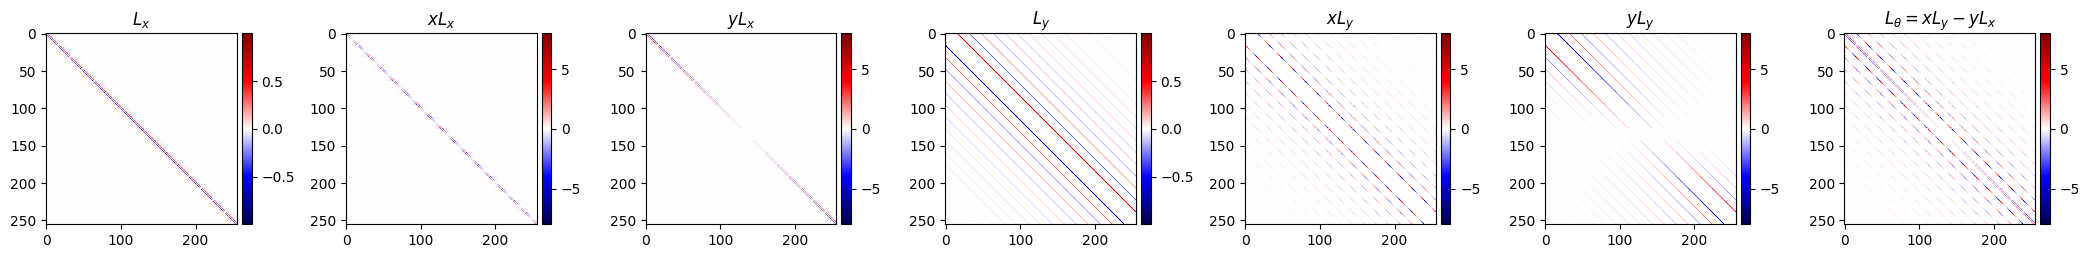

In [519]:
imshows(Ls, titles = Ls_titles, vminmaxs = 'separate')

In [520]:
ugen = UGenerator(dim = dim)

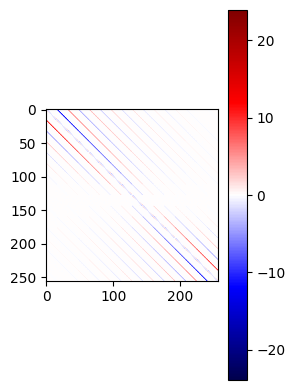

In [530]:
class Transformations(UGenerator):
    def __init__(self, dim):
        super().__init__(dim = dim)

    def scaling(self):
        return self.xLx + 3*self.yLy - 2*self.uLu

tf = Transformations(dim=dim)

imshows([tf.scaling()], vminmaxs = 'separate')

In [445]:
Lu = np.zeros((dim, dim))
uLu  = np.eye(dim)

expm(uLu)

array([[2.71828183, 0.        , 0.        , 0.        ],
       [0.        , 2.71828183, 0.        , 0.        ],
       [0.        , 0.        , 2.71828183, 0.        ],
       [0.        , 0.        , 0.        , 2.71828183]])

In [426]:
def get_L_exp(L, t: float = 1., u = False):

    if (L == 0).all():
        return t * np.eye(L.shape[0])

    assert (scipy.linalg.expm(t * L)  ==  np.eye(L.shape[0])).all()

    if u is False:
        return scipy.linalg.expm(t * L)
    elif u == 'usum':
        return scipy.linalg.expm(t * L) + t * np.eye(L.shape[0])
    elif u == 'uexp':
        return np.exp(t) * np.eye(L.shape[0])
    else:
        raise ValueError('Unknown u')
    
eps = 0.1
get_L_exp(np.zeros((dim, dim)), t = -2 * eps, u = 'uexp')

array([[0.81873075, 0.        , 0.        , 0.        ],
       [0.        , 0.81873075, 0.        , 0.        ],
       [0.        , 0.        , 0.81873075, 0.        ],
       [0.        , 0.        , 0.        , 0.81873075]])

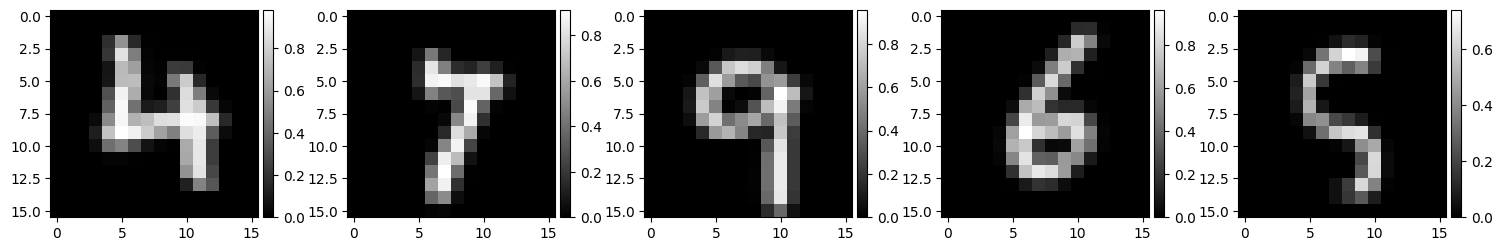

In [531]:
dataset = MnistDataset(mode='test', r = 0, dim = dim, N = N_samples, return_rot = False)
imshows(dataset[:].reshape(N_samples, dim, dim), imshow_kwargs = dict(cmap = 'gray'))

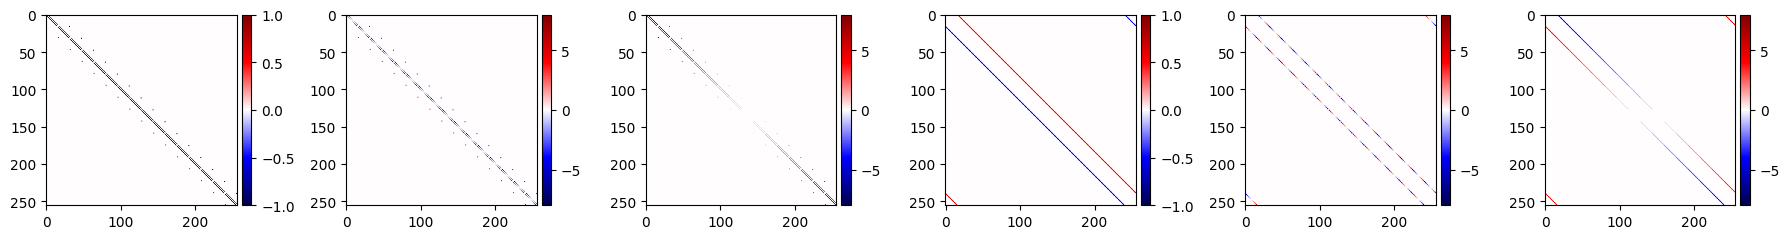

In [369]:
hard_gen = HardCodedGenerator(dim = dim)
Ls = hard_gen.D
imshows(Ls, vminmaxs = 'separate')


In [370]:
# i = 6
# for vals in zip(L[i], L_exp[i], x_org.reshape(-1)):
#     # print([f'{val:.5f}' for val in vals])
#     print([f'{val:.5f}' for val in vals])

In [371]:
# (L_exp[4] * x_org.reshape(-1)).sum()

In [564]:
(tran.yLx + tran.Lu == tran.yLx).all()

True

In [581]:
Lu = np.diag(np.full((dim**2), -1))

In [602]:
dataset

In [582]:
if (np.diag(Lu) == -1).all():
    np.fill_diagonal(Lu, 0)
    return scipy.linalg.expm(t * L) + t * np.eye(L.shape[0])

True

In [586]:
Lu

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [583]:
tran.Lx + Lu

array([[-1.        , -0.99678517,  0.4935579 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.99678517, -1.        , -0.99678517, ...,  0.        ,
         0.        ,  0.        ],
       [-0.4935579 ,  0.99678517, -1.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -1.        ,
        -0.99678517,  0.4935579 ],
       [ 0.        ,  0.        ,  0.        , ...,  0.99678517,
        -1.        , -0.99678517],
       [ 0.        ,  0.        ,  0.        , ..., -0.4935579 ,
         0.99678517, -1.        ]])

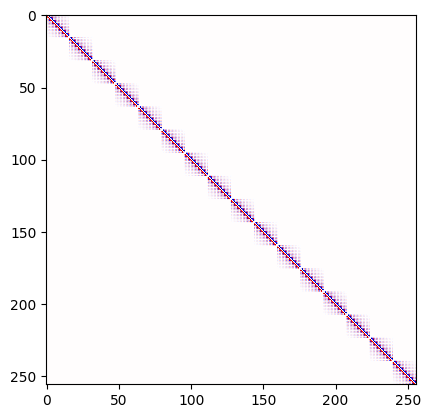

In [567]:
plt.imshow(tran.Lx)

In [ ]:
def get_L_exp(L, t: float = 1.):

    assert (np.diag(Lu) == -1).all() or (np.diag(Lu) == 0).all()

    
    L_exp = scipy.linalg.expm(t * L)

    if (np.diag(L) == -1).all():
        np.fill_diagonal(L, 0)
        L_exp += t * np.eye(L.shape[0])

    return L_exp

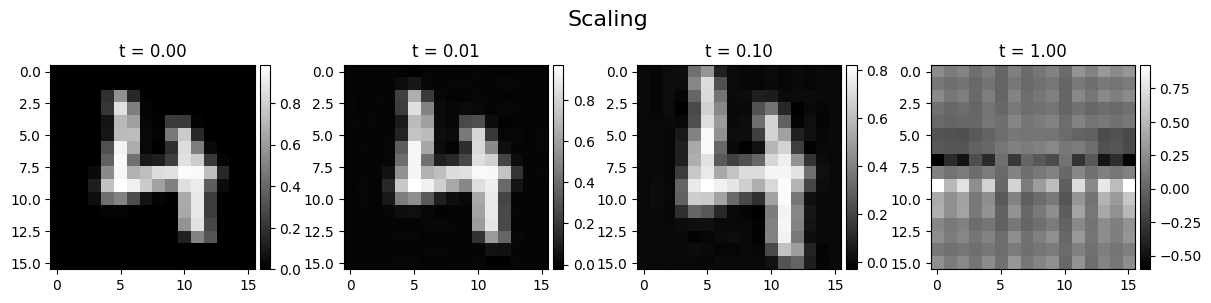

In [597]:
def plot_transfs(L, x_org, suptitle = None):
    
    ts = np.array([0, 0.01, 0.1, 1.])
    x = x_org.reshape(-1, 1)
    x_tranfs, L_exps = [], []

    for t in ts:
        L_exp = get_L_exp(L = L, t=t)
        x_transf = np.dot(L_exp, x).reshape(dim, dim)

        x_tranfs.append(x_transf)
        L_exps.append(L_exp)

    titles = [f't = {t:.2f}' for t in ts]
    imshows(x_tranfs, imshow_kwargs = dict(cmap = 'gray'), vminmaxs = None, titles = titles, suptitle = suptitle)
    # imshows(L_exps, imshow_kwargs = dict(cmap = 'seismic'), vminmaxs = 'separate', titles = titles, )

    return x_tranfs, L_exps

class Transformations(UGenerator):
    def __init__(self, dim):
        super().__init__(dim = dim)

    def space_translation(self):
        return self.Lx
    
    def galilean_boosting(self):
        return self.yLx - self.Lu
    
    def scaling(self):
        return self.xLx + 3*self.yLy - 2*self.uLu
    

tran = Transformations(dim=dim)

L, suptitle = tran.space_translation(), 'Space translation'
L, suptitle = tran.galilean_boosting(), 'Galilean boosting'
L, suptitle = tran.scaling(), 'Scaling'

x_org = dataset[0].squeeze().numpy()

x_tranfs, L_exps = plot_transfs(L = L, x_org = x_org, suptitle = suptitle)


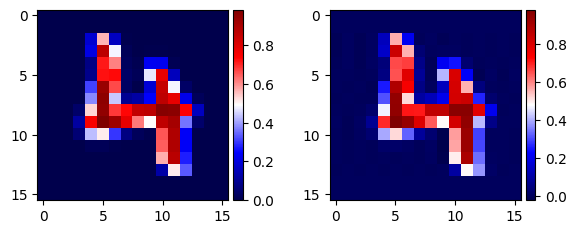

In [736]:
class Transformations(UGenerator):
    def __init__(self, dim):
        super().__init__(dim = dim)

    def space_translation(self):
        return self.Lx
    
    def galilean_boosting(self):
        return self.yLx - self.Lu
    
    def scaling(self):
        return self.xLx + 3*self.yLy - 2*self.uLu
    
def do_transf(L, x, t=1.):
    shape = x.shape
    x = x.reshape(-1, 1)
    return np.dot(get_L_exp(L,t), x).reshape(shape)


tran = Transformations(dim=dim)

L, suptitle = tran.galilean_boosting(), 'Galilean boosting'
L, suptitle = tran.scaling(), 'Scaling'
L, suptitle = tran.space_translation(), 'Space translation'

x_org = dataset[0].squeeze().numpy()

x_transf = do_transf(L, x_org, t=0.1)

imshows(np.stack([x_org, x_transf]))

  0%|          | 0/10 [00:00<?, ?it/s]

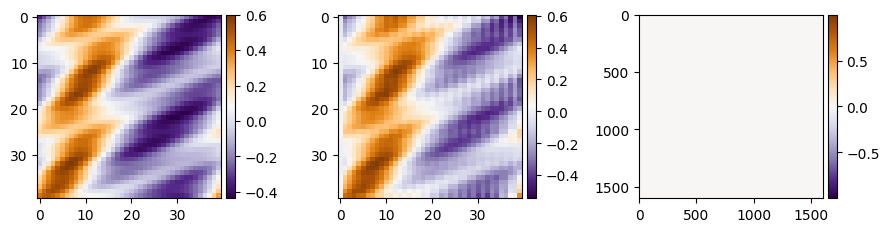

 10%|█         | 1/10 [00:02<00:21,  2.44s/it]

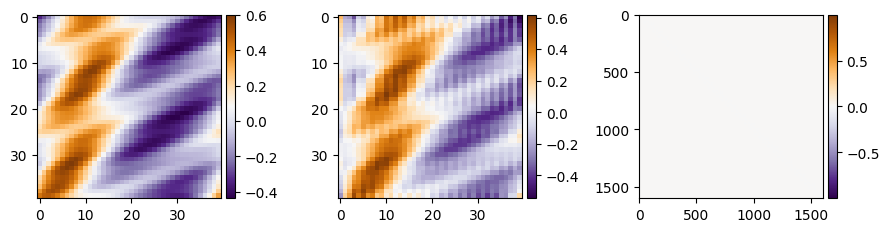

 20%|██        | 2/10 [00:05<00:20,  2.55s/it]

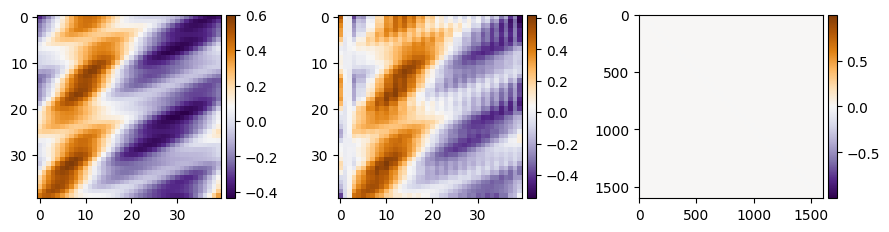

 30%|███       | 3/10 [00:07<00:17,  2.52s/it]

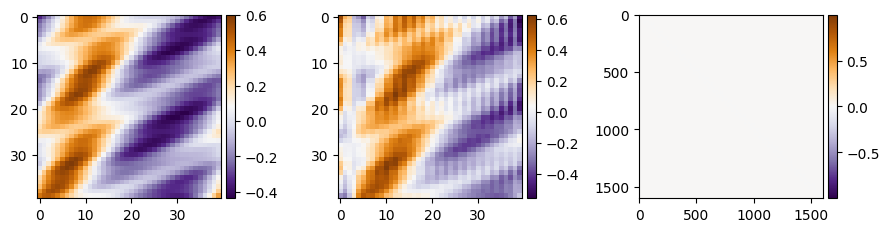

 40%|████      | 4/10 [00:10<00:15,  2.52s/it]

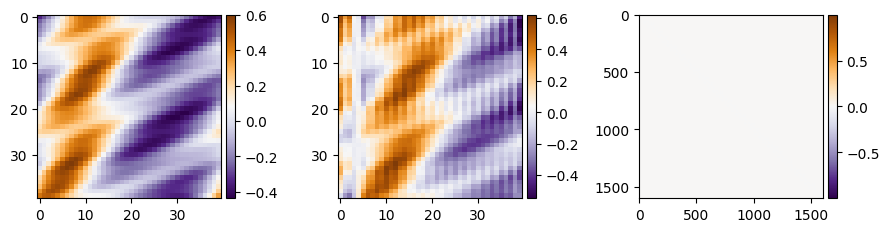

 50%|█████     | 5/10 [00:12<00:12,  2.50s/it]

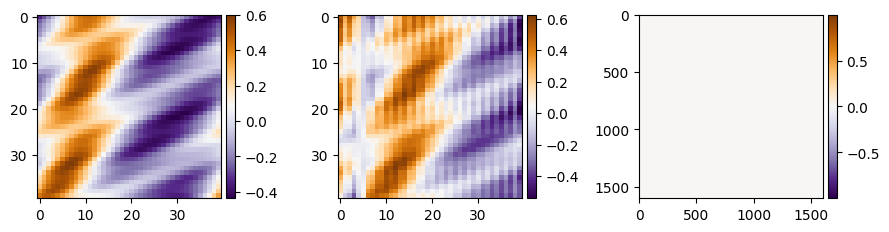

 60%|██████    | 6/10 [00:15<00:10,  2.51s/it]

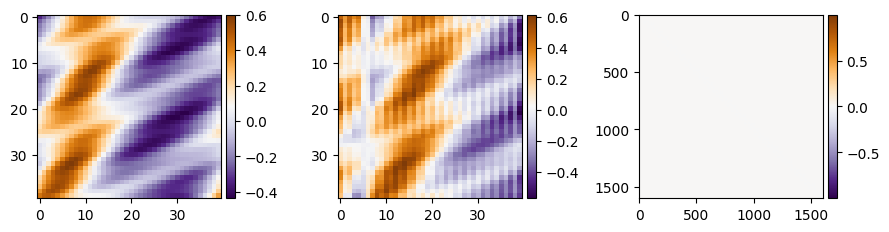

 70%|███████   | 7/10 [00:17<00:07,  2.49s/it]

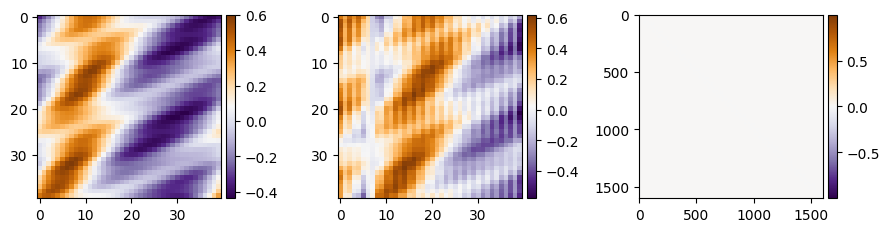

 80%|████████  | 8/10 [00:19<00:04,  2.45s/it]

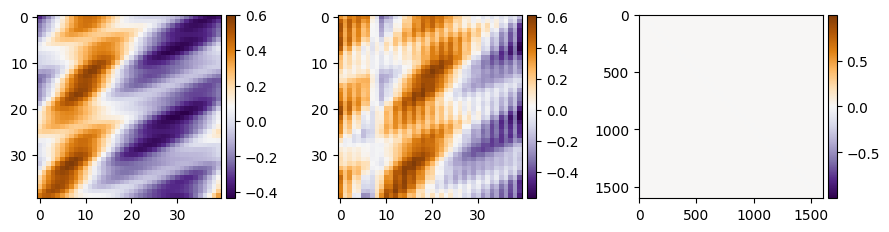

 90%|█████████ | 9/10 [00:22<00:02,  2.40s/it]

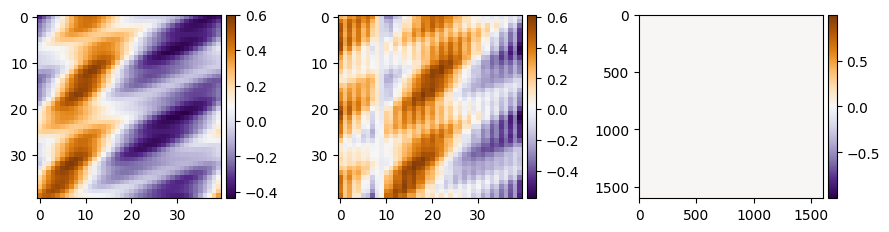

100%|██████████| 10/10 [00:24<00:00,  2.44s/it]


In [797]:
x_org, cmap = u.numpy(), 'PuOr_r'
# x_org, cmap = dataset[0].squeeze().numpy(), 'gray'

shapes = x_org.shape
assert np.array([shape == shapes[0] for shape in shapes]).all(), shapes
tran = Transformations(dim=shapes[0])

L, suptitle = tran.galilean_boosting(), 'Galilean boosting'
L, suptitle = tran.scaling(), 'Scaling'
L, suptitle = tran.space_translation(), 'Space translation'

x = x_org
for _ in tqdm(range(10)):
    x = do_transf(L, x, t=1.)
    x_transf = x
    imshows([x_org, x_transf, L], imshow_kwargs = dict(cmap = cmap))

# x_transf = do_transf(L, x_org, t=10)


In [9]:
def custom_augment(u, dx, dt, eps, aug_func):
    # Get coordinates
    X = d_to_coords(u, dx, dt)
    x, t = X.permute(2, 0, 1)[:2]

    u, x, t = aug_func(u, x, t, eps = eps)
    dx = x[0,1] - x[0, 0]
    dt = t[1,0] - t[0, 0]

    return u, dx, dt

pde_dataset = PDEDataset(pde_name = 'KdV', data_dir = '../data/test/', split = 'val')
u, dx, dt = pde_dataset[0]

Selecting 2 out of the 2 val samples!


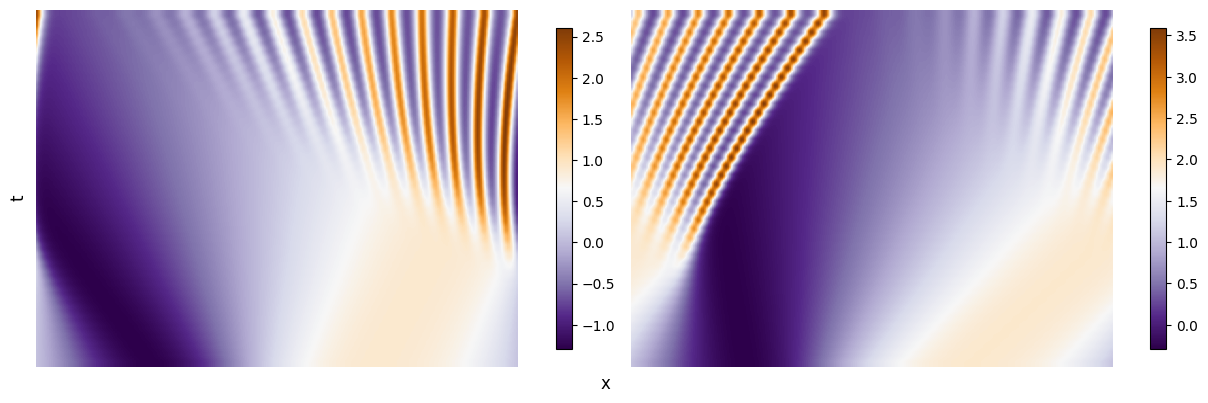

In [19]:
eps = torch.tensor([-1.])
u_aug, dx_aug, dt_aug = custom_augment(u.clone(), dx.clone(), dt.clone(), eps, pde_dataset.pde._u3)

us, dxs, dts = torch.stack([u, u_aug]), torch.stack([dx, dx_aug]), torch.stack([dt, dt_aug])
plot_1ds(us, dxs, dts, l = 0.5, ncols = len(us), nrows = 1)

In [807]:
(u_aug - u) / u 

tensor([[ 0.1806,  0.5292,  1.1920,  ..., -0.3423, -0.2115, -0.0457],
        [ 0.6464,  1.1373,  2.2651,  ..., -0.0471,  0.1313,  0.3486],
        [ 0.8192,  1.4187,  3.2062,  ...,  0.1557,  0.3070,  0.5079],
        ...,
        [-1.4348, -1.0977, -0.8774,  ...,  6.6025, -5.1672, -2.1442],
        [-1.2892, -1.0141, -0.7958,  ..., 41.5728, -3.1753, -1.7666],
        [-1.0541, -0.7933, -0.5454,  ..., -3.8899, -1.9855, -1.3907]])

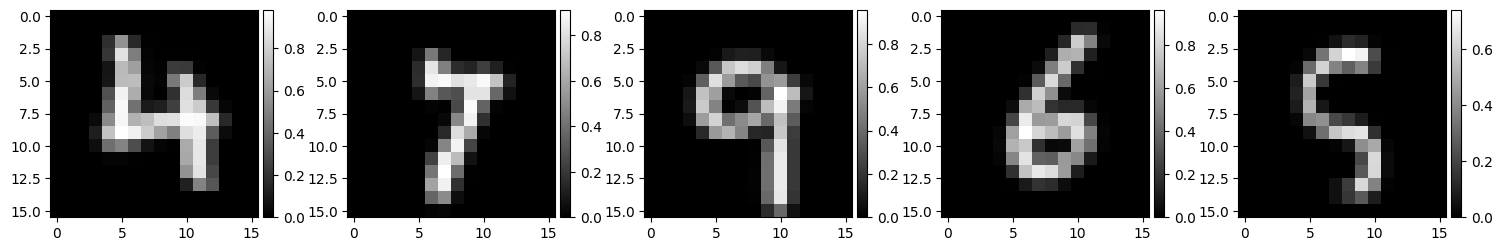

In [373]:
imshows(dataset[:].reshape(N_samples, dim, dim), imshow_kwargs = dict(cmap = 'gray'))

In [450]:
def get_L_exp(L, t: float = 1.):
    return scipy.linalg.expm(t * L)

def transf(L, x, t=1.):
    shape = x.shape
    x = x.reshape(-1, 1)
    return np.dot(get_L_exp(L,t), x).reshape(shape)

In [375]:
img = dataset[0].squeeze(0)
x_org = img

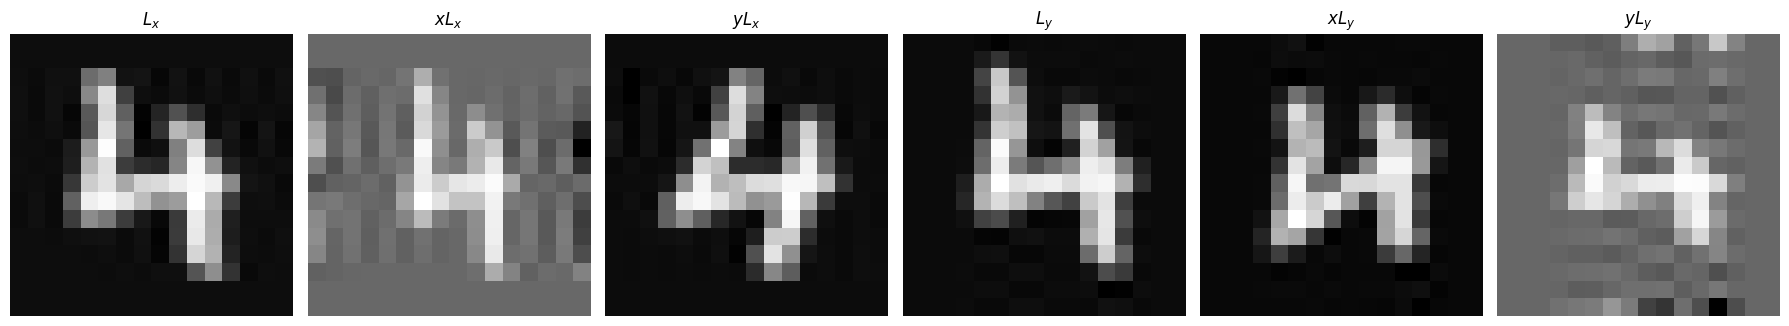

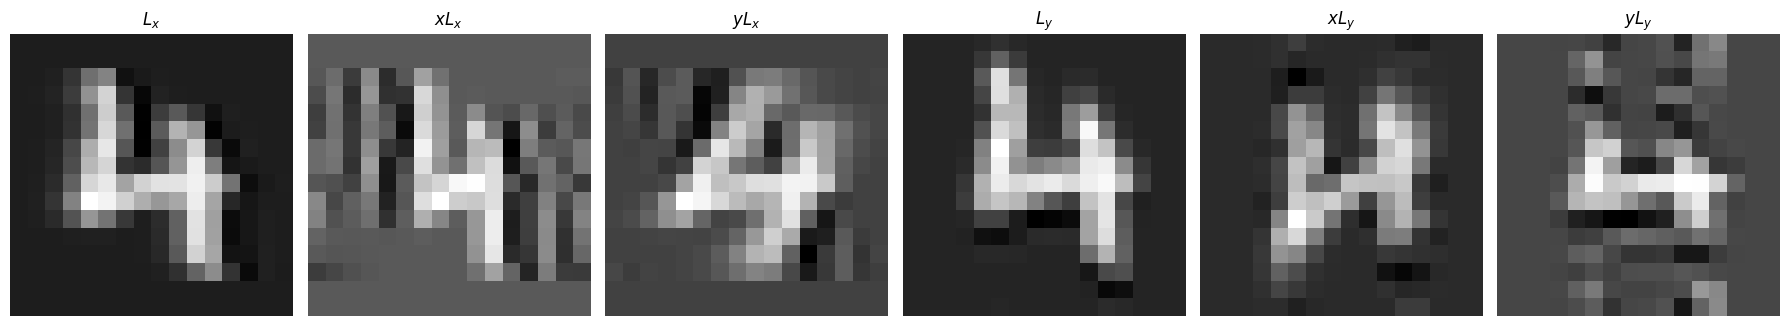

In [377]:
x_tranfs = [transf(L, x_org, t=0.4) for L in gen.D]
imshows(x_tranfs,imshow_kwargs = dict(cmap = 'gray'), vminmaxs = None, titles = Ls_titles,colorbar=False, axis_off = True)

x_tranfs = [transf(L, x_org, t=0.4) for L in hard_gen.D]
imshows(x_tranfs,imshow_kwargs = dict(cmap = 'gray'), vminmaxs = None, titles = Ls_titles,colorbar=False, axis_off = True)

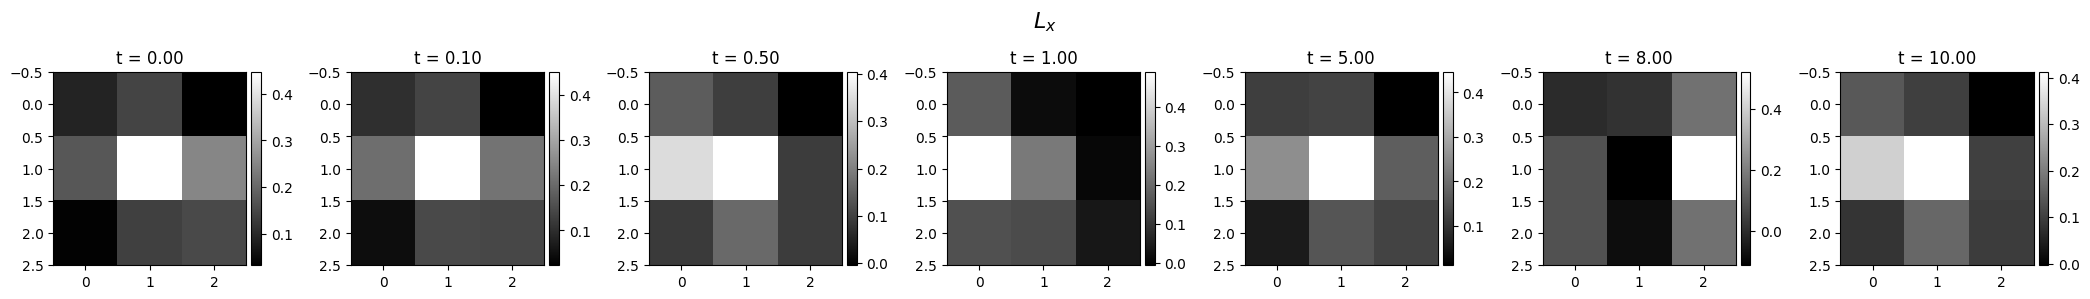

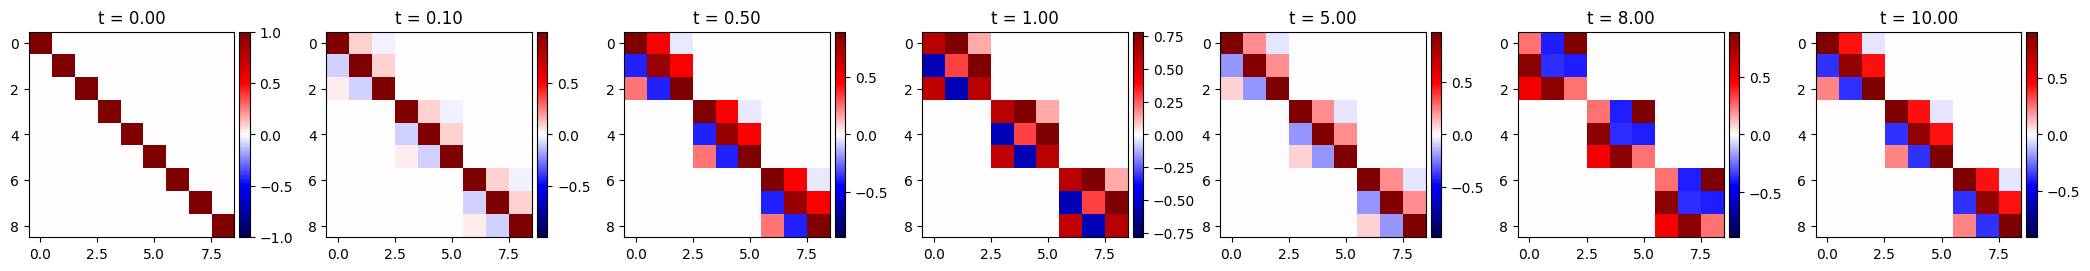

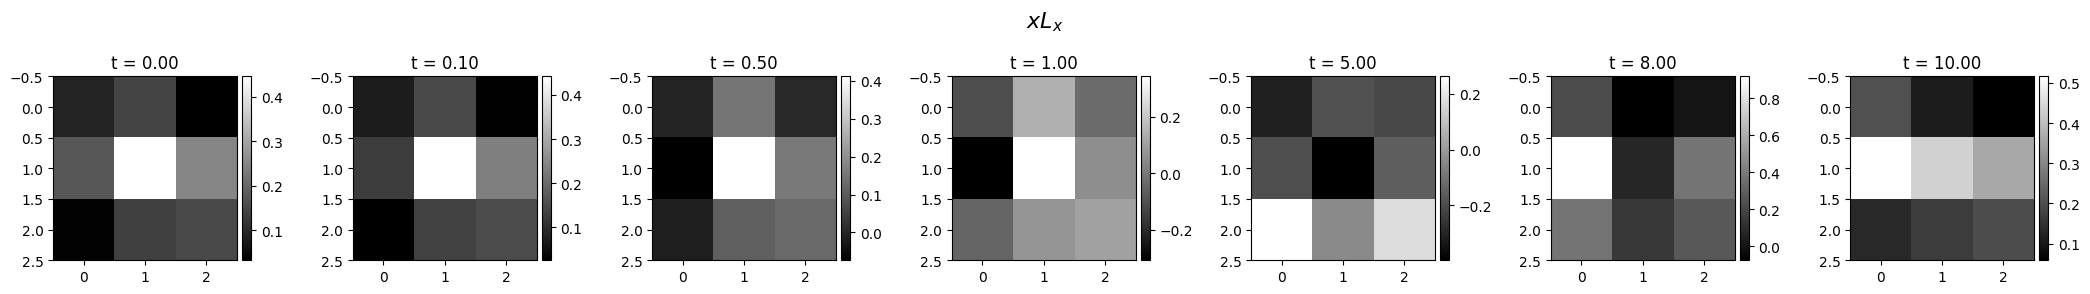

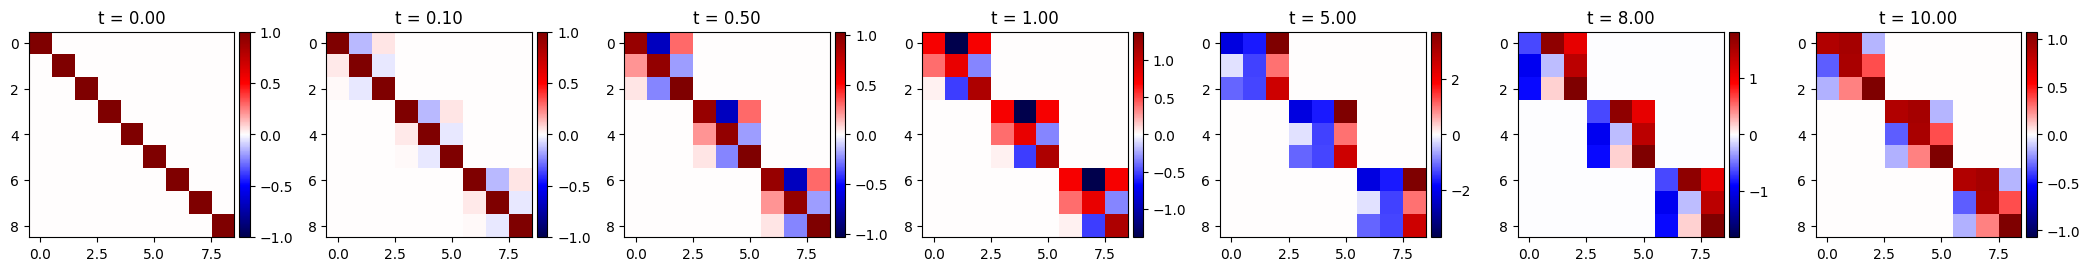

KeyboardInterrupt: 

In [213]:
def plot_transfs(L, x_org, suptitle = None):
    
    ts = np.array([0, 0.1, 0.5, 1., 5., 8., 10.])
    x = x_org.reshape(-1, 1)
    x_tranfs, L_exps = [], []

    for t in ts:
        L_exp = get_L_exp(L = L, t=t)
        x_transf = np.dot(L_exp, x).reshape(dim, dim)

        x_tranfs.append(x_transf)
        L_exps.append(L_exp)

    titles = [f't = {t:.2f}' for t in ts]
    imshows(x_tranfs, imshow_kwargs = dict(cmap = 'gray'), vminmaxs = None, titles = titles, suptitle = suptitle)
    imshows(L_exps, imshow_kwargs = dict(cmap = 'seismic'), vminmaxs = 'separate', titles = titles, )

    return x_tranfs, L_exps


img = dataset[0].squeeze(0)
x_org = img

for L, L_title in zip(Ls, Ls_titles):
    plot_transfs(L = L, x_org = x_org, suptitle = L_title)

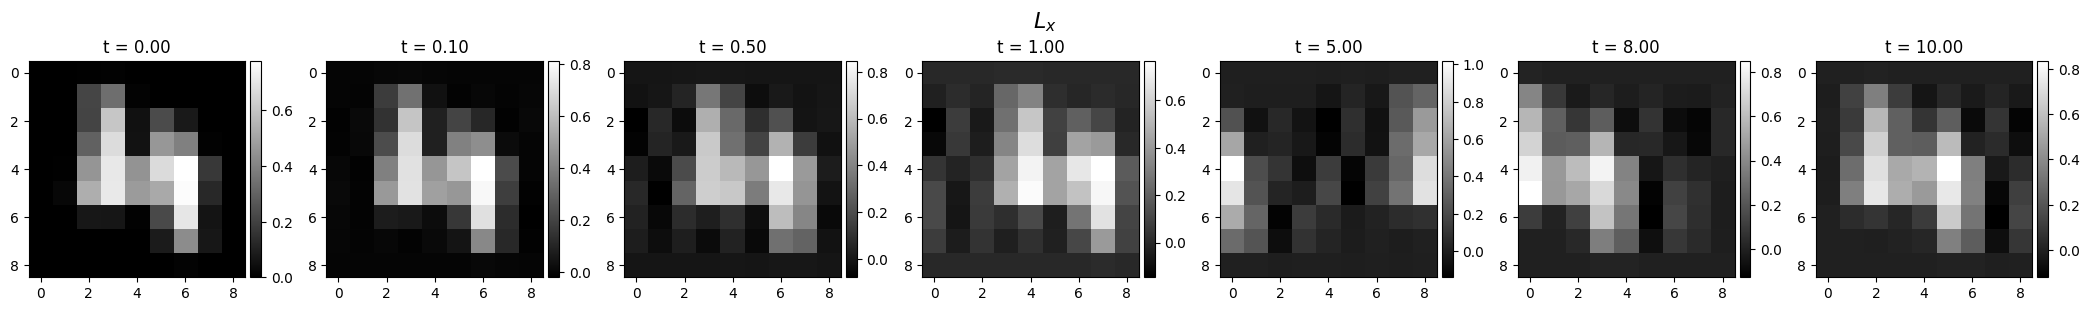

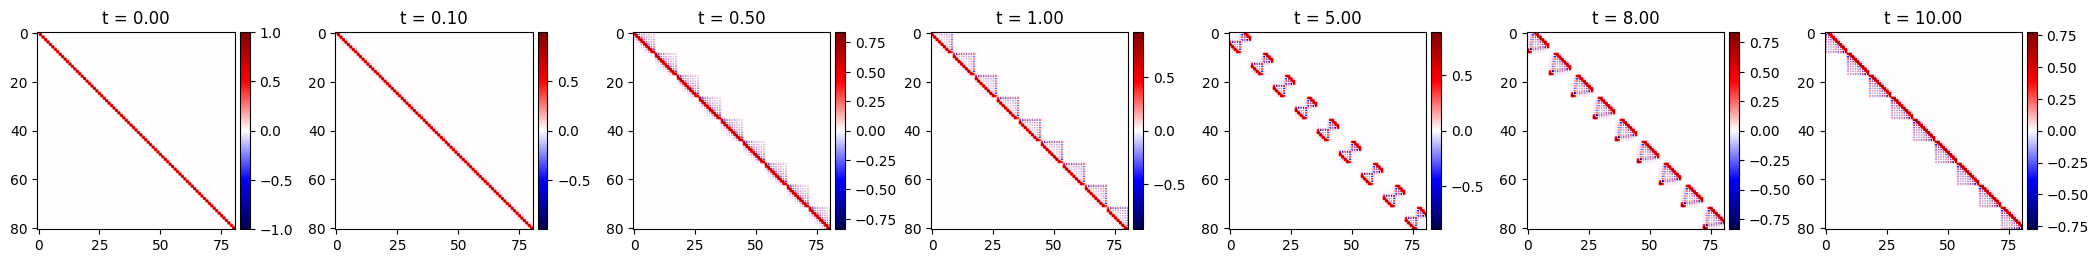

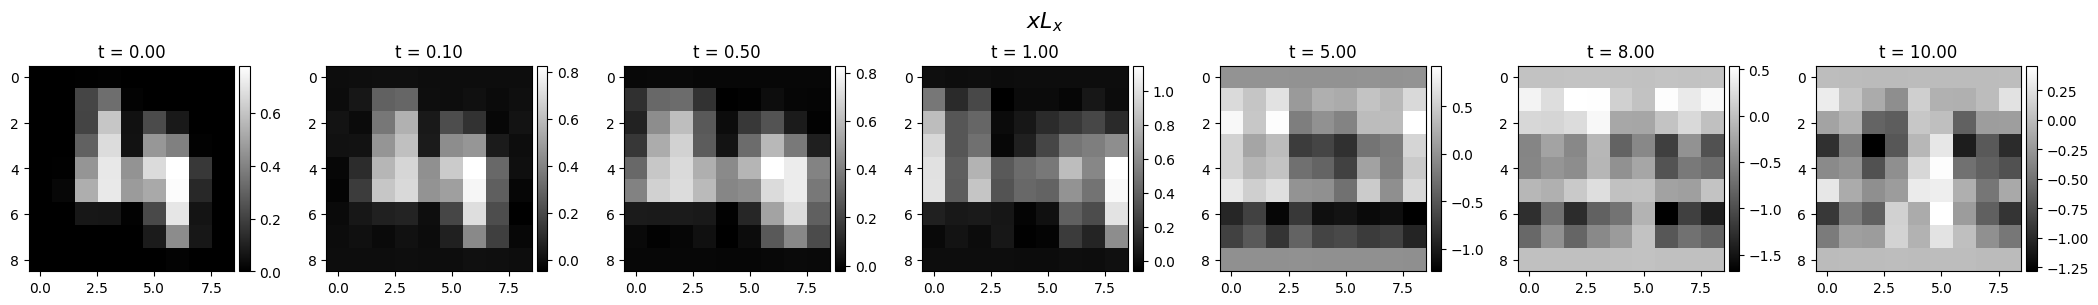

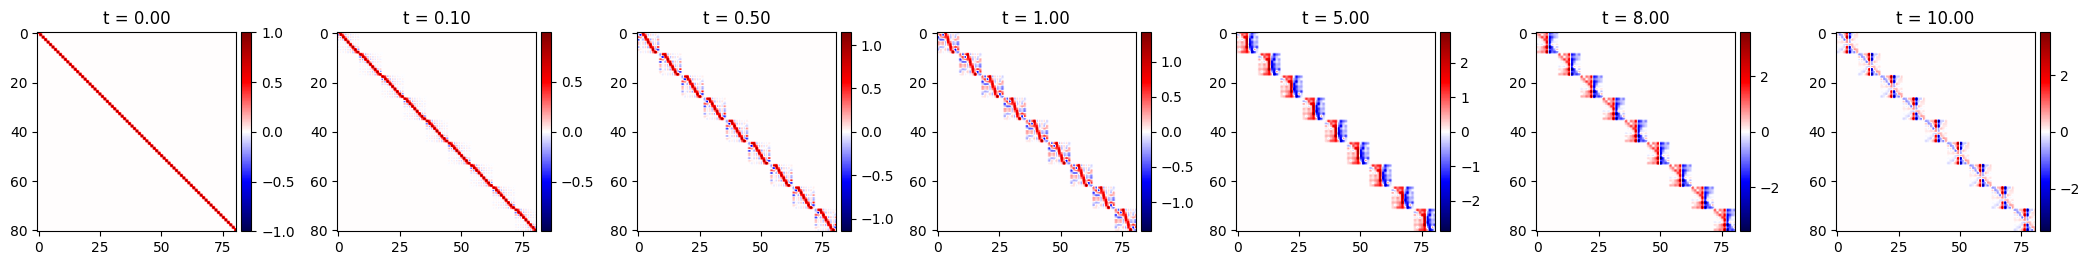

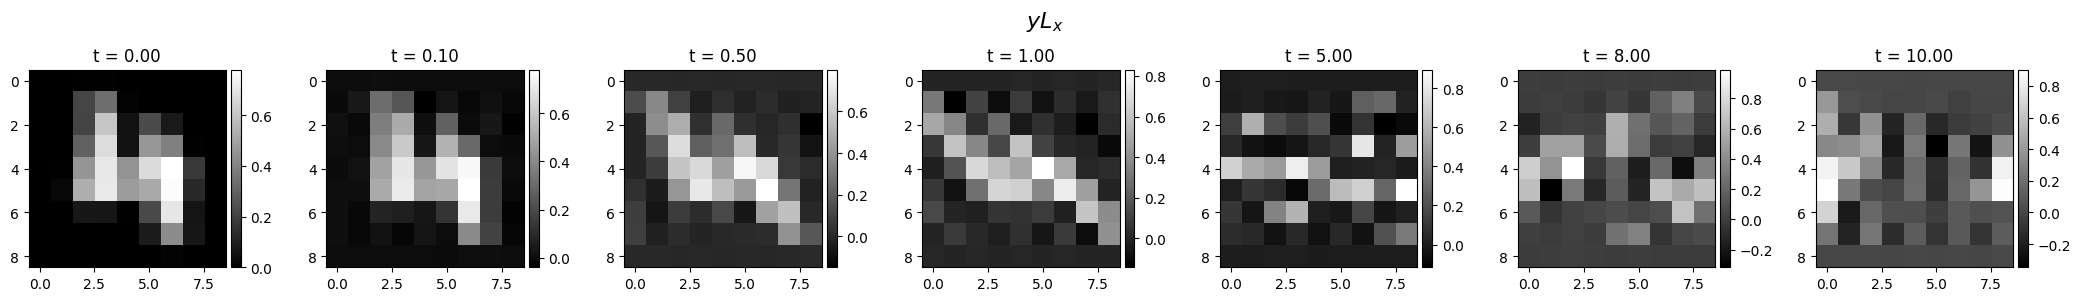

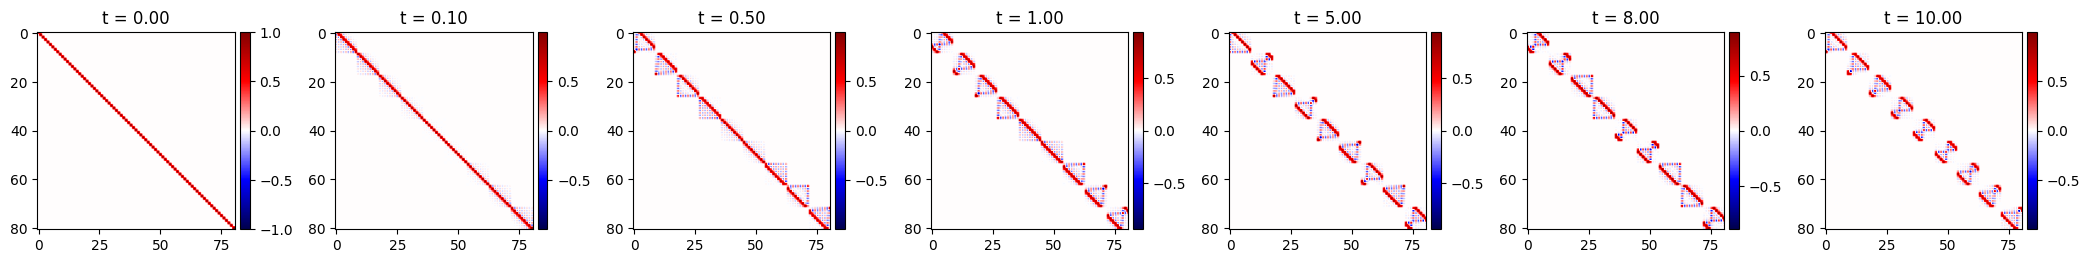

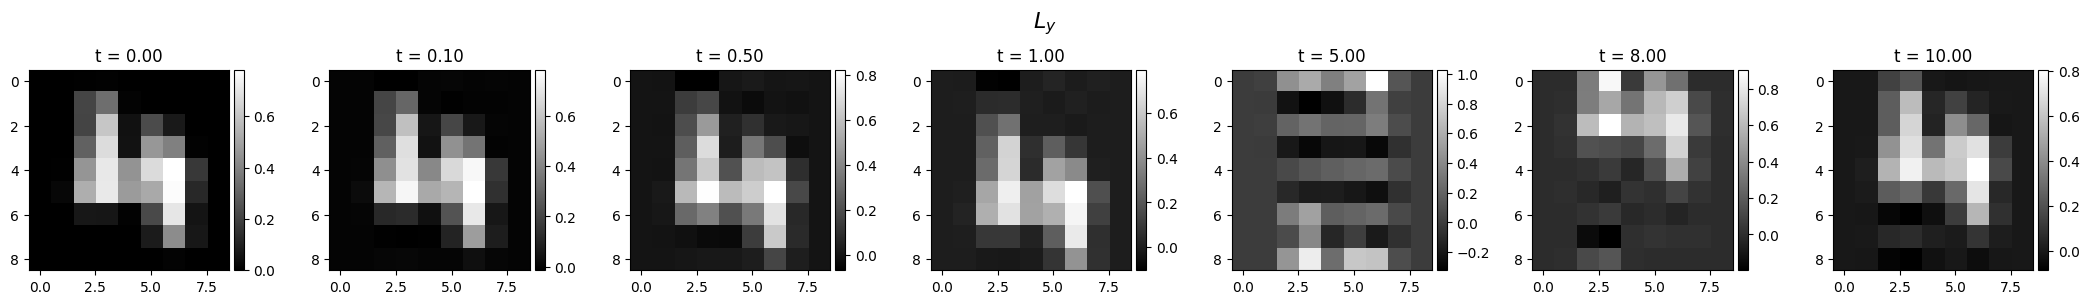

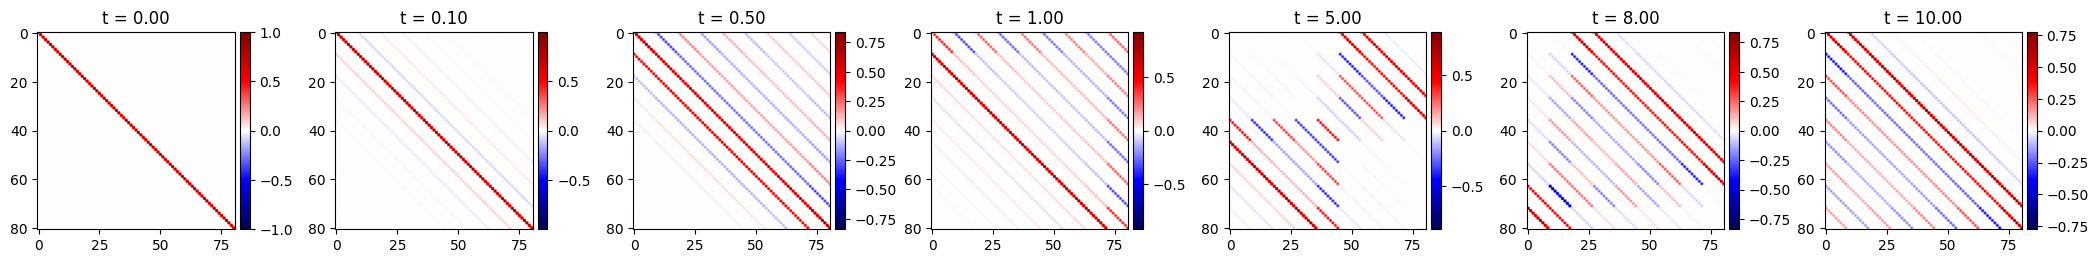

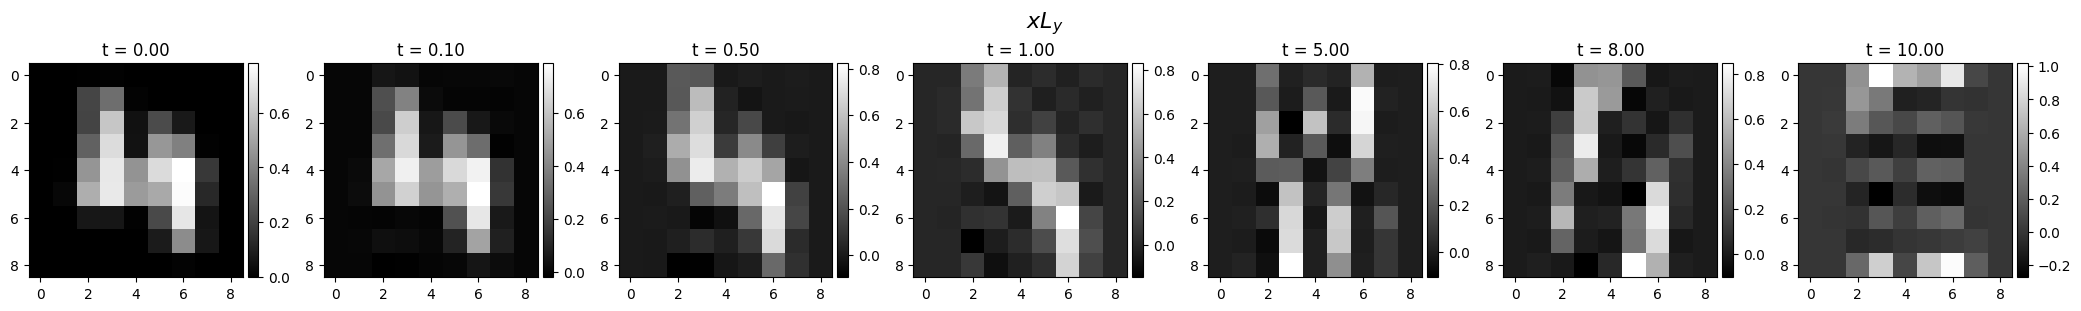

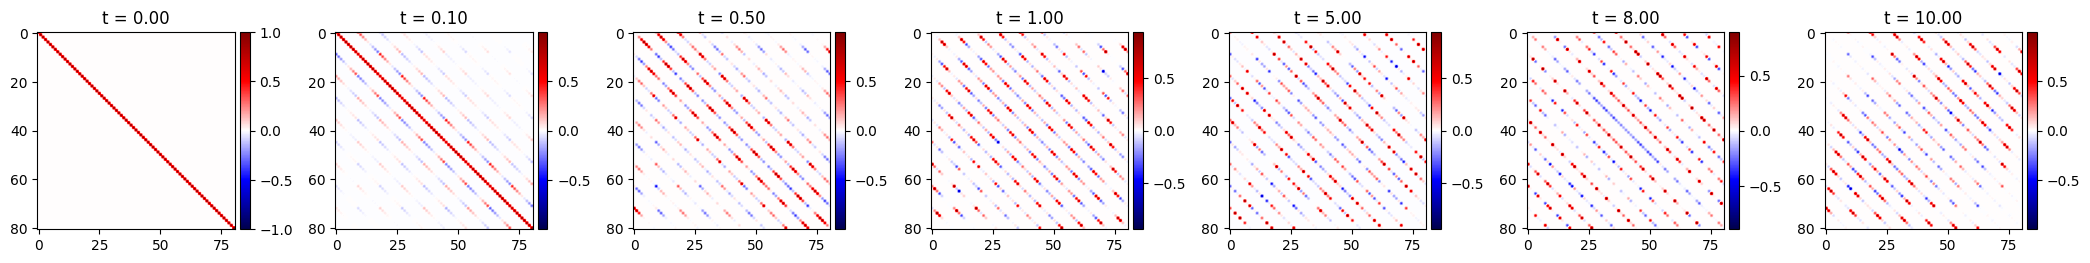

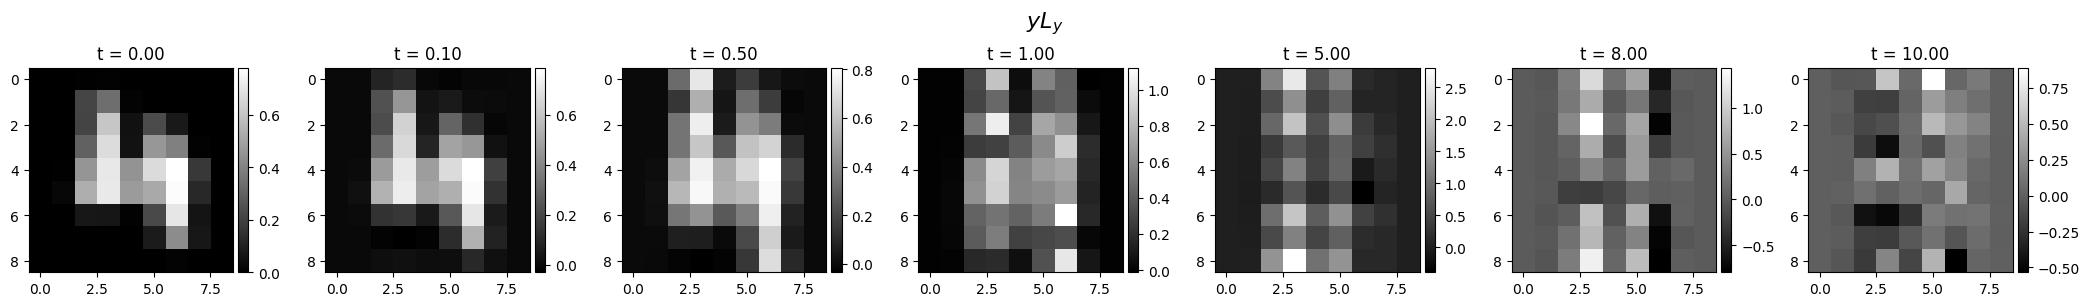

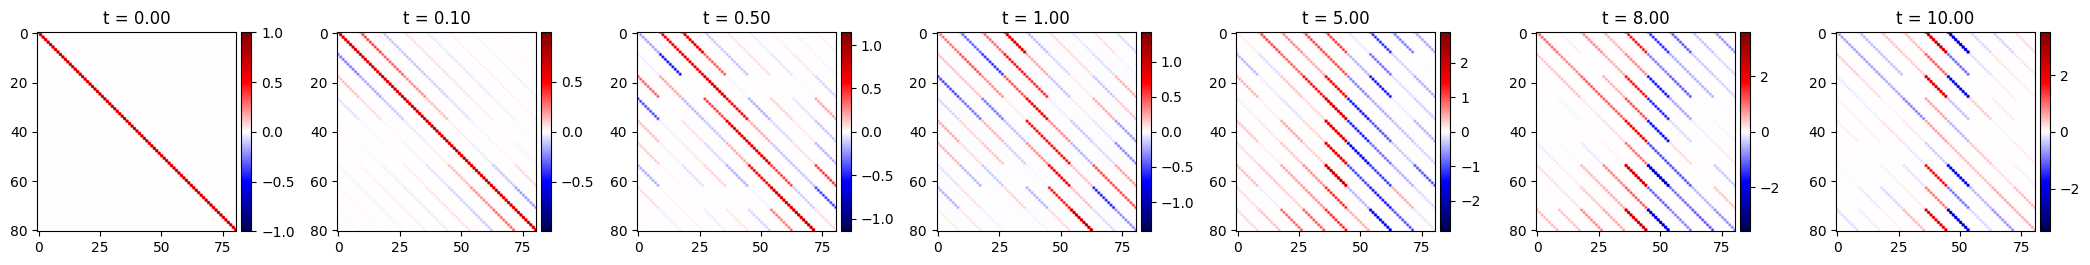

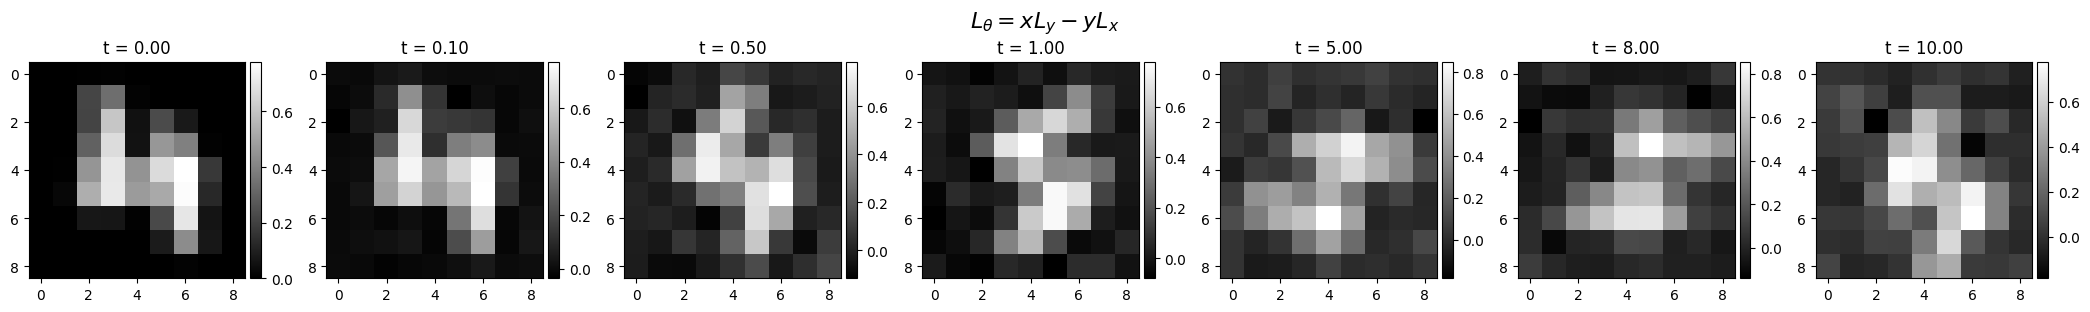

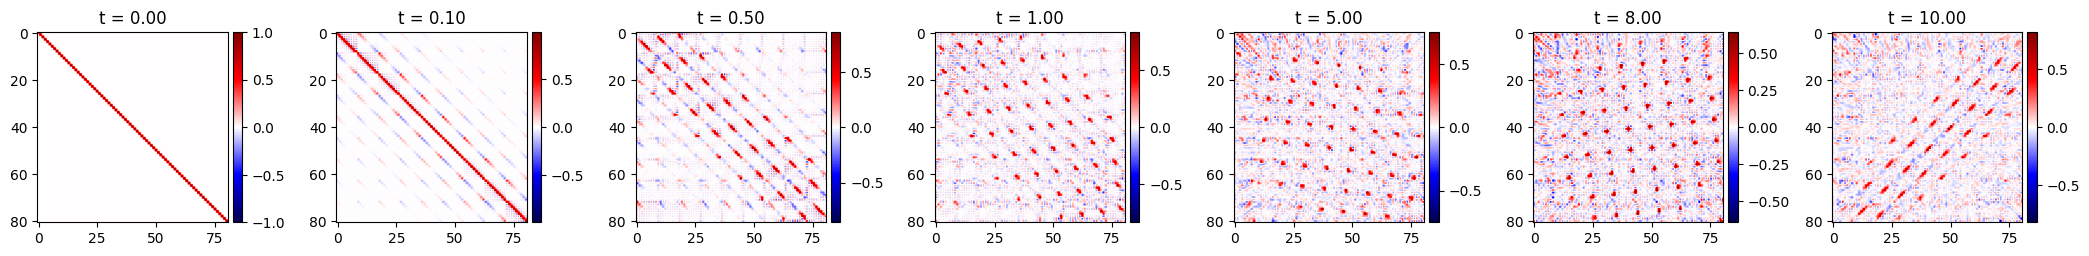

In [ ]:
def plot_transfs(L, x_org, suptitle = None):
    
    ts = np.array([0, 0.1, 0.5, 1., 5., 8., 10.])
    x = x_org.reshape(-1, 1)
    x_tranfs, L_exps = [], []

    for t in ts:
        L_exp = get_L_exp(L = L, t=t)
        x_transf = np.dot(L_exp, x).reshape(dim, dim)

        x_tranfs.append(x_transf)
        L_exps.append(L_exp)

    titles = [f't = {t:.2f}' for t in ts]
    imshows(x_tranfs, imshow_kwargs = dict(cmap = 'gray'), vminmaxs = None, titles = titles, suptitle = suptitle)
    imshows(L_exps, imshow_kwargs = dict(cmap = 'seismic'), vminmaxs = 'separate', titles = titles, )

    return x_tranfs, L_exps


img = dataset[0].squeeze(0)
x_org = img

for L, L_title in zip(Ls, Ls_titles):
    plot_transfs(L = L, x_org = x_org, suptitle = L_title)

### Notes
- Large $t$ in $e^{tL}$ produces artefacts